In [2]:
# ============================================================
# 04. Importar librerías
# ============================================================

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos de ML
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Configuración de estilo de gráficos
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

# ============================================================
# 2. Cargar datos
# ============================================================
RAW_DIR = "../data/raw"

# Usaremos Cerrillos como ejemplo (puedes cambiar por Maipú)
buildings = gpd.read_file(f"{RAW_DIR}/osm_buildings_cerrillos.geojson").to_crs(epsg=32719)

# Crear columna con el área de cada edificio
buildings["area_m2"] = buildings.geometry.area

print(" Datos cargados")
print(f"Número de edificios: {len(buildings)}")


 Datos cargados
Número de edificios: 4016


In [3]:
# ============================================================
# 3. Crear features espaciales
# ============================================================

# Centroides
buildings["centroid"] = buildings.geometry.centroid
buildings["x"] = buildings.centroid.x
buildings["y"] = buildings.centroid.y

# Logaritmo del área (target a predecir)
buildings["log_area"] = np.log1p(buildings["area_m2"])

# Densidad local: número de edificios a menos de 100m
buildings["neighbors_100m"] = buildings.centroid.apply(
    lambda p: buildings[buildings.centroid.distance(p) < 100].shape[0]
)

# Distancia al límite comunal
limite = gpd.read_file(f"{RAW_DIR}/cerrillos_limite.shp").to_crs(epsg=32719)
buildings["dist_border"] = buildings.centroid.distance(limite.unary_union)

# Seleccionar variables explicativas (X) y target (y)
X = buildings[["x", "y", "neighbors_100m", "dist_border"]]
y = buildings["log_area"]

print(" Features creadas")
X.head()


 Features creadas


,x,y,neighbors_100m,dist_border
0,341236.754722,6.292633e+06,2,0.0
1,338523.904451,6.290973e+06,7,0.0
2,341447.655746,6.289212e+06,1,0.0
3,341251.812360,6.288934e+06,1,0.0
4,341371.576945,6.289585e+06,1,0.0


In [4]:
# ============================================================
# 4. Dividir en train y test
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Tamaño train:", X_train.shape)
print("Tamaño test:", X_test.shape)


Tamaño train: (3212, 4)
Tamaño test: (804, 4)


In [5]:
# ============================================================
# 5. Entrenar modelos
# ============================================================

# Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# XGBoost
xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print(" Modelos entrenados")


 Modelos entrenados


 Random Forest - RMSE: 0.68, R²: 0.715
 XGBoost - RMSE: 0.74, R²: 0.665


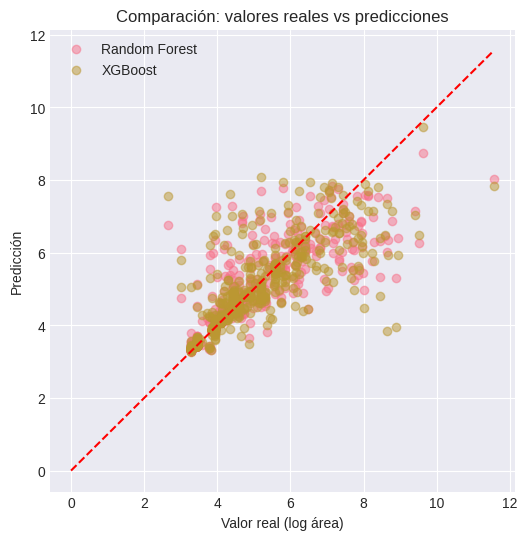

In [6]:
# ============================================================
# 6. Evaluación de modelos
# ============================================================

def evaluate(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f" {model_name} - RMSE: {rmse:.2f}, R²: {r2:.3f}")

evaluate(y_test, y_pred_rf, "Random Forest")
evaluate(y_test, y_pred_xgb, "XGBoost")

# Visualizar comparación de predicciones vs reales
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, label="Random Forest")
plt.scatter(y_test, y_pred_xgb, alpha=0.5, label="XGBoost")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Valor real (log área)")
plt.ylabel("Predicción")
plt.legend()
plt.title("Comparación: valores reales vs predicciones")
plt.show()


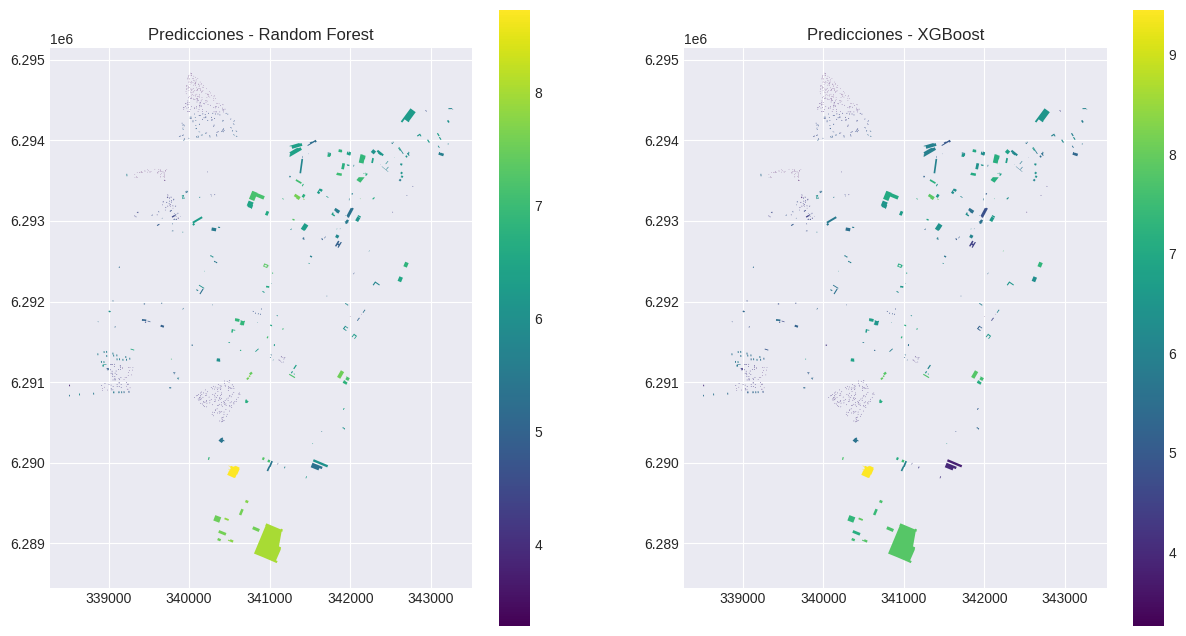

In [7]:
# ============================================================
# 7. Predicciones espaciales
# ============================================================

# Guardar predicciones en los edificios
buildings.loc[X_test.index, "pred_rf"] = y_pred_rf
buildings.loc[X_test.index, "pred_xgb"] = y_pred_xgb

# Mapas comparativos
fig, ax = plt.subplots(1,2, figsize=(15,8))
buildings.plot(ax=ax[0], column="pred_rf", cmap="viridis", legend=True)
ax[0].set_title("Predicciones - Random Forest")

buildings.plot(ax=ax[1], column="pred_xgb", cmap="viridis", legend=True)
ax[1].set_title("Predicciones - XGBoost")

plt.show()


In [10]:
# ============================================================
# 🔹 Calcular y almacenar métricas en variables
# ============================================================

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Random Forest
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

# XGBoost
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"Random Forest → RMSE: {rmse_rf:.2f}, R²: {r2_rf:.3f}")
print(f"XGBoost → RMSE: {rmse_xgb:.2f}, R²: {r2_xgb:.3f}")
# ============================================================
# 🔹 GUARDAR RESULTADOS DE MACHINE LEARNING
# ============================================================

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

OUTPUT_DIR = Path("../outputs/reports")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# --- 1. Guardar métricas de desempeño ---
results = pd.DataFrame({
    "Modelo": ["Random Forest", "XGBoost"],
    "RMSE": [rmse_rf, rmse_xgb],
    "R²": [r2_rf, r2_xgb]
})
results.to_csv(OUTPUT_DIR / "ml_metrics.csv", index=False)
print("✅ Métricas guardadas en outputs/reports/ml_metrics.csv")

# --- 2. Guardar predicciones espaciales ---
# (nos aseguramos de tener columnas con las predicciones)
buildings.loc[X_test.index, "pred_rf"] = y_pred_rf
buildings.loc[X_test.index, "pred_xgb"] = y_pred_xgb

# Si existe una columna centroid, eliminarla antes de exportar
if "centroid" in buildings.columns:
    buildings = buildings.drop(columns=["centroid"])

# Guardar el GeoDataFrame con las predicciones
buildings.to_file(OUTPUT_DIR / "ml_results.geojson", driver="GeoJSON")
print("✅ Predicciones espaciales guardadas en outputs/reports/ml_results.geojson")

# --- 3. Guardar gráfico comparativo de predicciones ---
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(y_test, y_pred_rf, alpha=0.5, label="Random Forest")
ax.scatter(y_test, y_pred_xgb, alpha=0.5, label="XGBoost")
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
ax.set_xlabel("Valor real (log área)")
ax.set_ylabel("Predicción")
ax.legend()
ax.set_title("Comparación: valores reales vs predicciones")
plt.savefig(OUTPUT_DIR / "ml_comparacion.png", dpi=300, bbox_inches="tight")
plt.close()
print("✅ Gráfico de comparación guardado en outputs/reports/ml_comparacion.png")

# --- 4. Guardar mapas de predicciones ---
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
buildings.plot(ax=axes[0], column="pred_rf", cmap="viridis", legend=True)
axes[0].set_title("Predicción - Random Forest")
buildings.plot(ax=axes[1], column="pred_xgb", cmap="viridis", legend=True)
axes[1].set_title("Predicción - XGBoost")
plt.savefig(OUTPUT_DIR / "ml_mapas_predicciones.png", dpi=300, bbox_inches="tight")
plt.close()
print("✅ Mapas de predicciones guardados en outputs/reports/ml_mapas_predicciones.png")

print("🎯 Todos los resultados de Machine Learning exportados correctamente.")


Random Forest → RMSE: 0.68, R²: 0.715
XGBoost → RMSE: 0.74, R²: 0.665
✅ Métricas guardadas en outputs/reports/ml_metrics.csv
✅ Predicciones espaciales guardadas en outputs/reports/ml_results.geojson
✅ Gráfico de comparación guardado en outputs/reports/ml_comparacion.png
✅ Mapas de predicciones guardados en outputs/reports/ml_mapas_predicciones.png
🎯 Todos los resultados de Machine Learning exportados correctamente.
